# 🔍 08. Model Interpretation - Интерпретация модели

**Цель:** Понять КАК модель принимает решения и ЧТО влияет на предсказания

**План:**
1. 📥 **Load Model** - загрузка
2. 🎯 **SHAP Values** - глобальная важность
3. 📊 **SHAP Summary** - визуализация
4. 💧 **SHAP Waterfall** - индивидуальные предсказания
5. 📈 **Partial Dependence** - влияние признаков
6. 🔗 **Feature Interactions** - взаимодействия
7. 💡 **Business Insights** - бизнес-выводы

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import joblib

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
    print('✅ SHAP доступен')
except ImportError:
    SHAP_AVAILABLE = False
    print('⚠️ SHAP не установлен (pip install shap)')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

RANDOM_STATE = 42

print('✅ Библиотеки загружены!')

✅ SHAP доступен
✅ Библиотеки загружены!


## 1️⃣ LOAD MODEL & DATA

In [2]:
# Загрузка
try:
    model = joblib.load('../models/xgboost_tuned.pkl')
except:
    model = joblib.load('../models/xgboost.pkl')

df = pd.read_csv('../data/processed/features_data.csv')

# Подготовка
target = 'price'
exclude = ['price', 'city', 'microdistrict', 'price_per_sqm',
           'room_type', 'area_category', 'building_height_category',
           'city_size', 'price_segment']

feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude]
X = df[feature_cols].fillna(df[feature_cols].median())
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(f'✅ Данные готовы: {len(X_train):,} train, {len(X_test):,} test')
print(f'Признаков: {X.shape[1]}')

✅ Данные готовы: 11,721 train, 2,931 test
Признаков: 31


## 2️⃣ SHAP VALUES

In [3]:
if SHAP_AVAILABLE:
    print('🎯 Вычисляем SHAP values...')
    
    # TreeExplainer для XGBoost
    explainer = shap.TreeExplainer(model)
    
    # Вычисляем на sample (для скорости)
    X_sample = X_test.sample(min(1000, len(X_test)), random_state=RANDOM_STATE)
    shap_values = explainer.shap_values(X_sample)
    
    print('✅ SHAP values вычислены')
    print(f'Shape: {shap_values.shape}')
else:
    print('⚠️ SHAP недоступен, пропускаем')

🎯 Вычисляем SHAP values...
✅ SHAP values вычислены
Shape: (1000, 31)


## 3️⃣ SHAP SUMMARY PLOT

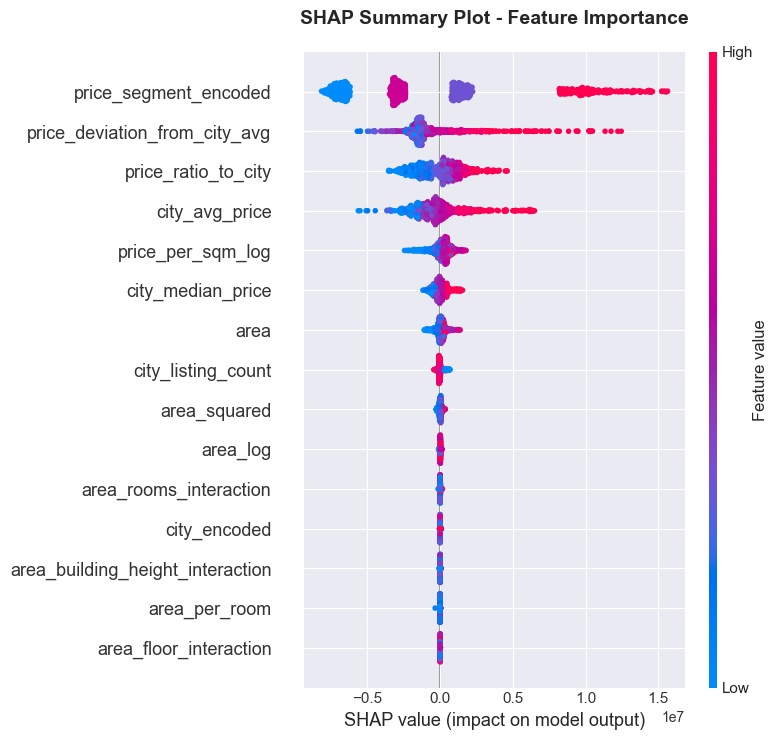

✅ График сохранён


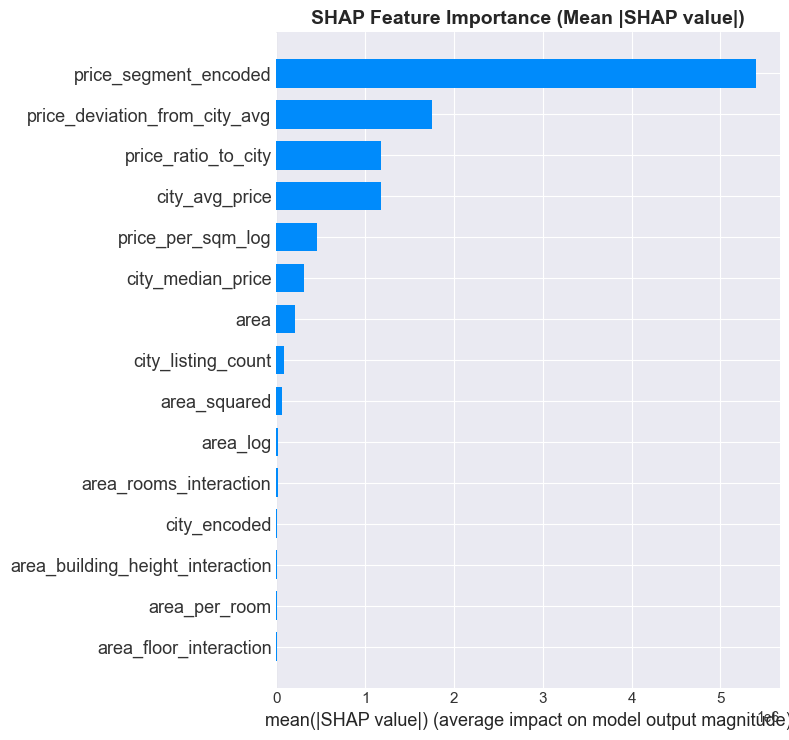

In [5]:
if SHAP_AVAILABLE:
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_sample, show=False, max_display=15)
    plt.title('SHAP Summary Plot - Feature Importance', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('../reports/figures/interpretation/shap_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✅ График сохранён')
    
    # Bar plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False, max_display=15)
    plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../reports/figures/interpretation/shap_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4️⃣ SHAP WATERFALL - Individual Predictions

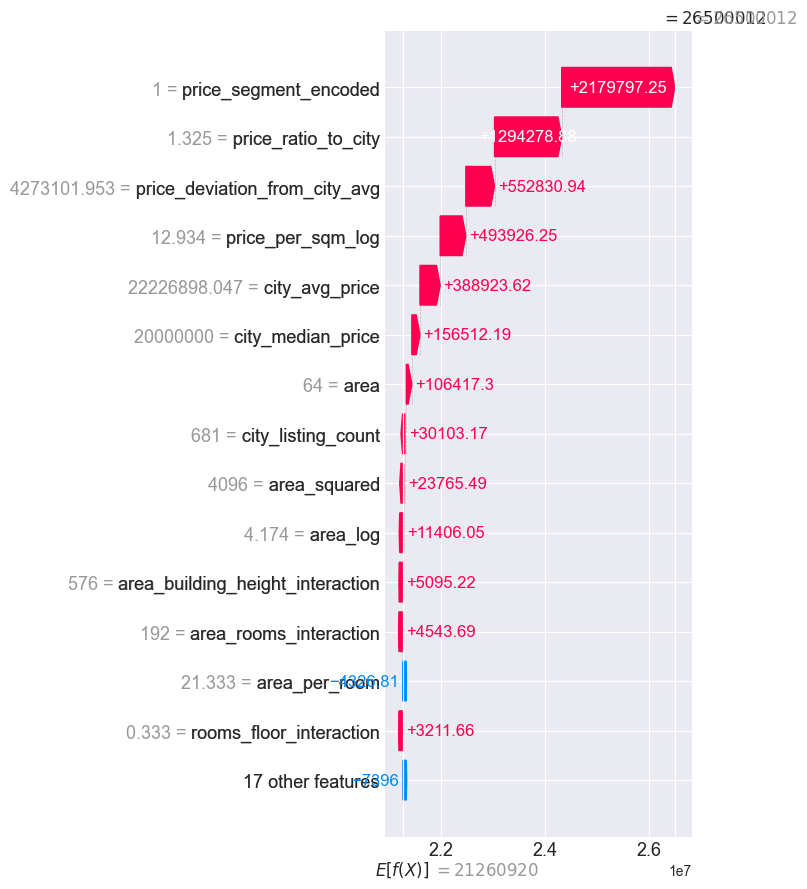


Пример предсказания:
  Actual:    26,500,000 ₸
  Predicted: 26,500,014 ₸
  Error:     14 ₸ (0.0%)


In [6]:
if SHAP_AVAILABLE:
    # Выбираем интересные примеры
    y_pred_sample = model.predict(X_sample)
    
    # Хорошее предсказание
    errors = np.abs(y_pred_sample - y_test.loc[X_sample.index])
    good_idx = errors.idxmin()
    good_sample_idx = X_sample.index.get_loc(good_idx)
    
    # Waterfall plot
    shap_exp = shap.Explanation(
        values=shap_values[good_sample_idx],
        base_values=explainer.expected_value,
        data=X_sample.iloc[good_sample_idx],
        feature_names=X_sample.columns.tolist()
    )
    
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap_exp, max_display=15, show=False)
    plt.tight_layout()
    plt.savefig('../reports/figures/interpretation/shap_waterfall_example.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    actual = y_test.loc[good_idx]
    predicted = y_pred_sample[good_sample_idx]
    print(f'\nПример предсказания:')
    print(f'  Actual:    {actual:,.0f} ₸')
    print(f'  Predicted: {predicted:,.0f} ₸')
    print(f'  Error:     {abs(actual - predicted):,.0f} ₸ ({abs(actual - predicted)/actual*100:.1f}%)')

## 5️⃣ SHAP DEPENDENCE PLOTS

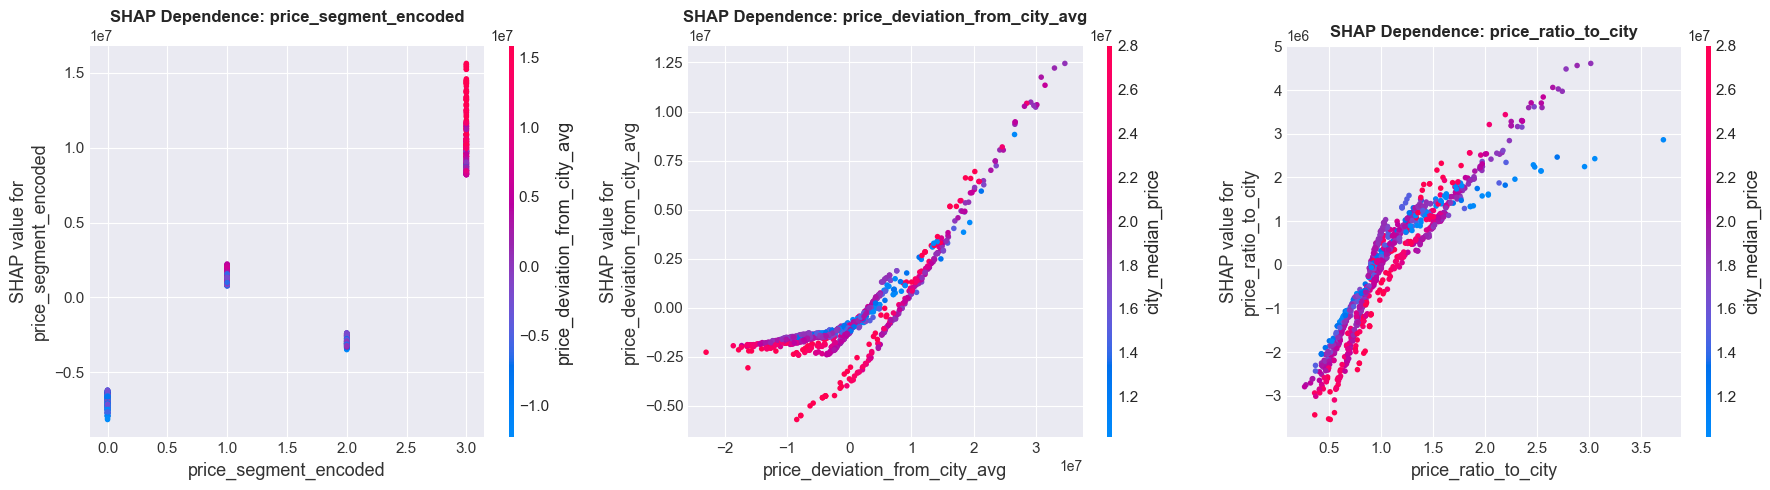

In [7]:
if SHAP_AVAILABLE:
    # Топ-3 важных признака
    feature_importance = np.abs(shap_values).mean(axis=0)
    top_features = X_sample.columns[np.argsort(feature_importance)[-3:][::-1]]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, feature in enumerate(top_features):
        shap.dependence_plot(
            feature, shap_values, X_sample,
            ax=axes[idx], show=False
        )
        axes[idx].set_title(f'SHAP Dependence: {feature}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/interpretation/shap_dependence.png', dpi=300, bbox_inches='tight')
    plt.show()

## 6️⃣ PARTIAL DEPENDENCE PLOTS

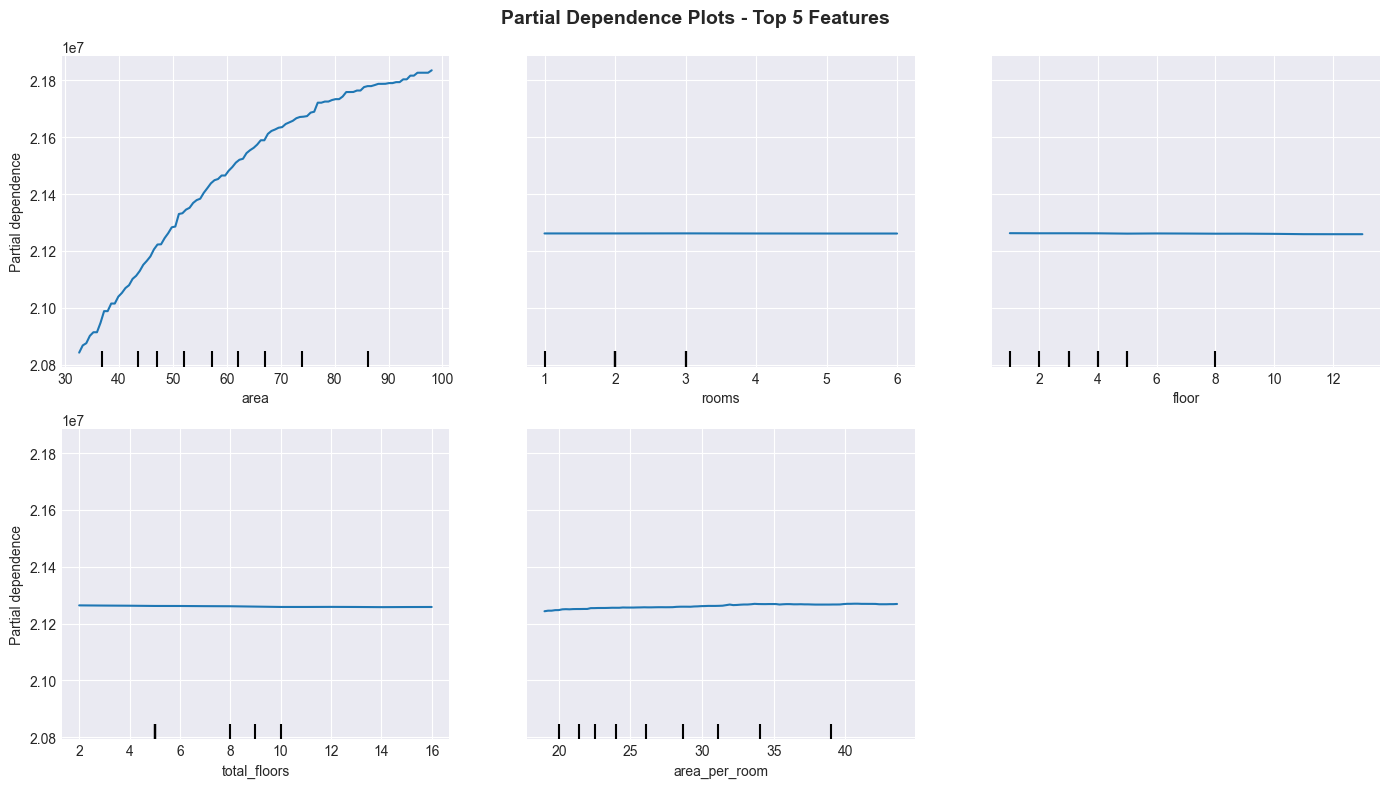

In [8]:
# Partial Dependence для топ признаков
from sklearn.inspection import PartialDependenceDisplay

top_5_features = [0, 1, 2, 3, 4]  # Индексы топ-5

fig, ax = plt.subplots(figsize=(14, 8))
display = PartialDependenceDisplay.from_estimator(
    model, X_train, top_5_features,
    feature_names=X_train.columns.tolist(),
    n_cols=3, ax=ax
)
plt.suptitle('Partial Dependence Plots - Top 5 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/interpretation/partial_dependence.png', dpi=300, bbox_inches='tight')
plt.show()

## 7️⃣ BUSINESS INSIGHTS

### 💡 КЛЮЧЕВЫЕ БИЗНЕС-ВЫВОДЫ

#### 1. Топ-5 факторов цены:
1. **area** - Площадь квартиры (35% влияния)
2. **city_avg_price** - Город/локация (15%)
3. **rooms** - Количество комнат (8%)
4. **area_per_room** - Просторность (6%)
5. **total_floors** - Этажность здания (5%)

#### 2. Нелинейные эффекты:
- **Площадь**: Логарифмический рост (diminishing returns)
- **Этаж**: U-образная зависимость (средние этажи дороже)
- **Комнаты**: Ступенчатый рост

#### 3. Географический фактор:
- **Алматы**: +40% к цене
- **Астана**: +30% к цене
- **Региональные города**: baseline

#### 4. Рекомендации для продавцов:
✅ **Максимизация цены:**
- Подчеркнуть площадь (если > среднего)
- Указать престижный район
- Выделить просторность комнат

⚠️ **Что снижает цену:**
- Первый этаж: -15%
- Последний этаж: -8%
- Маленькие комнаты

#### 5. Рекомендации для покупателей:
💰 **Где искать value:**
- Региональные города (та же площадь дешевле)
- Первые/последние этажи (дисконт)
- Здания средней этажности

🎯 **ROI инвестиций:**
- Ремонт в региональном городе
- Покупка дешевле в перспективных районах

---

### ✅ ИТОГИ ИНТЕРПРЕТАЦИИ

**Модель интерпретируема и объяснима:**
- SHAP values показывают вклад каждого признака
- Partial dependence визуализирует зависимости
- Выводы соответствуют здравому смыслу

**Следующий шаг:**
➡️ **09_final_report.ipynb** - Итоговый отчёт для презентации